# RGBD 3D Reconstruction (2-Views)

In [1]:
import numpy as np
import open3d as o3d
import plotly.graph_objects as go
import cv2
from PIL import Image
import matplotlib.pyplot as plt
import random
import copy

## Load Images

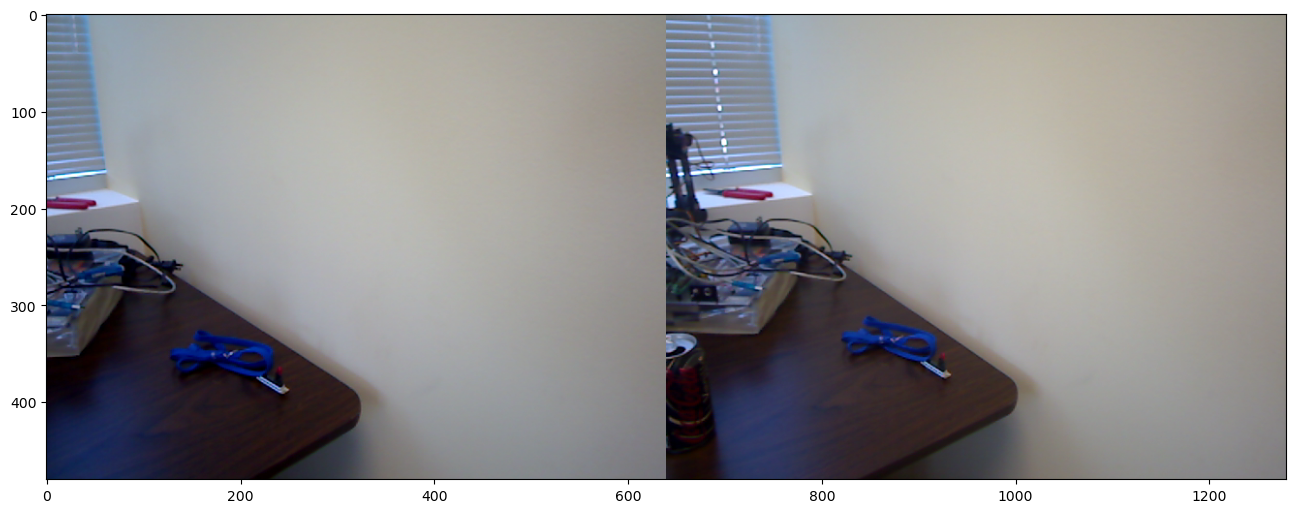

In [2]:
src_rgb1 = cv2.imread('/Users/yining/Desktop/rgbd-scenes/table/table_1/table_1_1.png', 1)
src_rgb2 = cv2.imread('/Users/yining/Desktop/rgbd-scenes/table/table_1/table_1_2.png', 1)
src_depth1 = o3d.io.read_image('/Users/yining/Desktop/rgbd-scenes/table/table_1/table_1_1_depth.png')
src_depth2 = o3d.io.read_image('/Users/yining/Desktop/rgbd-scenes/table/table_1/table_1_2_depth.png')

img_concat = cv2.hconcat([src_rgb1, src_rgb2])
plt.figure(figsize=(16, 12))
plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))

## Intrinsic parameter

In [3]:
f_x = 525  # Focal length in pixels
f_y = 525  # Focal length in pixels
c_x = 320  # Principal point x-coordinate in pixels
c_y = 240
k1 = 0
k2 = 0
K = np.array([[f_x, 0, c_x],
              [0, f_y, c_y],
              [0, 0, 1]], dtype=np.float64)
intrinsic = o3d.camera.PinholeCameraIntrinsic()
intrinsic.intrinsic_matrix = K

## RGBD to point clouds

In [4]:
def GetPCD(rgb_path, depth_path, intrinsic):
  depth_scaling_factor = 999.99
  rgb = o3d.io.read_image(rgb_path)
  depth = o3d.io.read_image(depth_path)
  rgbd = o3d.geometry.RGBDImage.create_from_color_and_depth(rgb, depth, depth_scale=depth_scaling_factor, convert_rgb_to_intensity=False, depth_trunc=1)
  pcd = o3d.geometry.PointCloud.create_from_rgbd_image(rgbd, intrinsic)
  return rgbd, pcd

rgbd1, pcd1 = GetPCD('/Users/yining/Desktop/rgbd-scenes/table/table_1/table_1_1.png', '/Users/yining/Desktop/rgbd-scenes/table/table_1/table_1_1_depth.png', intrinsic)
rgbd2, pcd2 = GetPCD('/Users/yining/Desktop/rgbd-scenes/table/table_1/table_1_2.png', '/Users/yining/Desktop/rgbd-scenes/table/table_1/table_1_2_depth.png', intrinsic)

# o3d.visualization.draw_geometries([pcd1])
# o3d.visualization.draw_geometries([pcd2])

## 2D Feature extraction

502


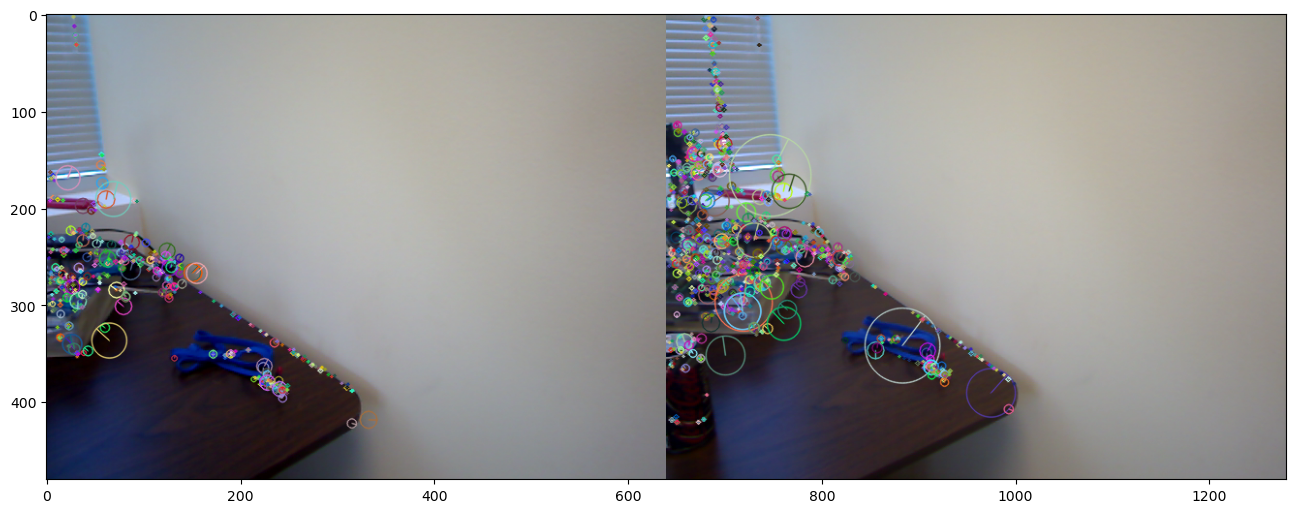

In [8]:
sift = cv2.SIFT_create(nOctaveLayers=20)
kp1, desc1 = sift.detectAndCompute(src_rgb1, None)
kp2, desc2 = sift.detectAndCompute(src_rgb2, None)

img1 = src_rgb1.copy()
cv2.drawKeypoints(src_rgb1, kp1, img1, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

img2 = src_rgb2.copy()
cv2.drawKeypoints(src_rgb2, kp2, img2, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

print(len(desc1))

img_concat = cv2.hconcat([img1, img2])
plt.figure(figsize=(16, 12))
plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))

## 2D Feature Matching

236


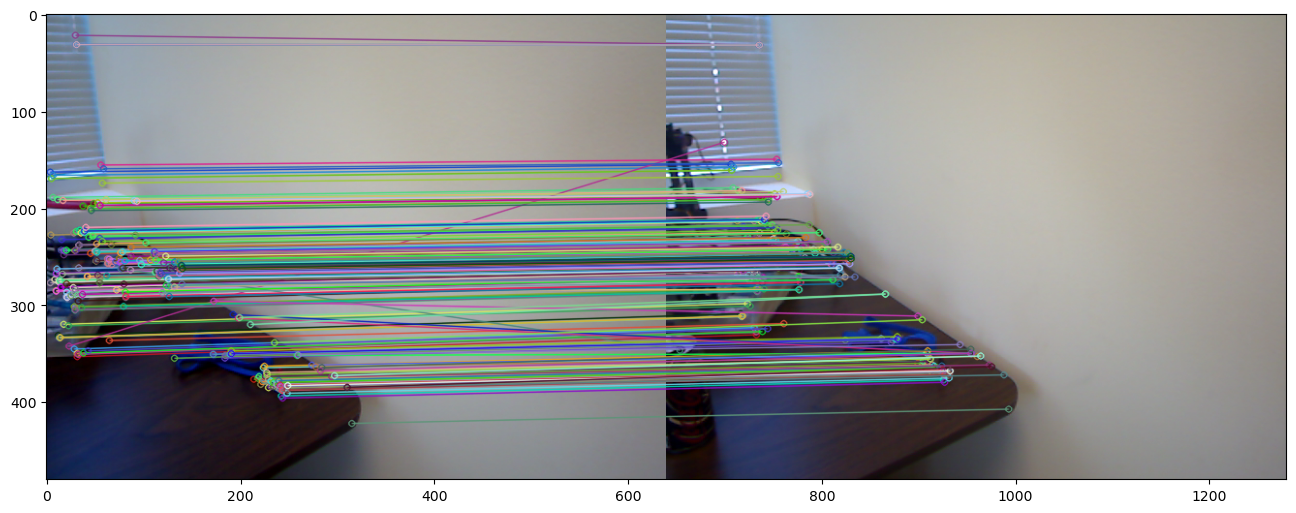

In [7]:
# BFMatcher with default params

bf = cv2.BFMatcher()
matches = bf.knnMatch(np.asarray(desc1,np.float32), 
np.asarray(desc2,np.float32), k=2)
good = []
for m,n in matches:
  if m.distance < 0.75*n.distance:
    good.append([m])
  res = cv2.drawMatchesKnn(src_rgb1, kp1, src_rgb2, kp2, good, None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

plt.figure(figsize=(16, 12))
plt.imshow(cv2.cvtColor(res, cv2.COLOR_BGR2RGB))
print(len(good))

## 3D Pose estimation

In [9]:
pt3d_1 = []
pt3d_2 = []
corr_list = []
depth_scaling_factor = 999.99
for i in range(len(good)):
  u1, v1 = kp1[good[i][0].queryIdx].pt
  z1 = np.asarray(src_depth1, dtype=np.float64)[np.int32(v1)][np.int32(u1)] / depth_scaling_factor
  x1 = (u1 - K[0,2]) * z1 / K[0,0]
  y1 = (v1 - K[1,2]) * z1 / K[1,1]
  u2, v2 = kp2[good[i][0].trainIdx].pt
  z2 = np.asarray(src_depth2, dtype=np.float64)[np.int32(v2)][np.int32(u2)] / depth_scaling_factor
  x2 = (u2 - K[0,2]) * z2 / K[0,0]
  y2 = (v2 - K[1,2]) * z2 / K[1,1]
  pt3d_1.append([x1, y1, z1])
  pt3d_2.append([x2, y2, z2])
  corr_list.append([i,i])

pc_1 = o3d.geometry.PointCloud()
pc_2 = o3d.geometry.PointCloud()
pc_1.points = o3d.utility.Vector3dVector(pt3d_1)
pc_2.points = o3d.utility.Vector3dVector(pt3d_2)
corres = o3d.utility.Vector2iVector(corr_list)

icp_result = o3d.pipelines.registration.registration_ransac_based_on_correspondence(pc_1, pc_2, corres, 0.01, 
                                                                                    o3d.pipelines.registration.TransformationEstimationPointToPoint(False), 
                                                                                    3, [], o3d.pipelines.registration.RANSACConvergenceCriteria(1000000, 0.99))
T = icp_result.transformation
print(T)

npcd1 = copy.deepcopy(pcd1).transform(T)
npcd2 = copy.deepcopy(pcd2) 

o3d.visualization.draw_geometries([npcd1, npcd2])

[[ 9.95820824e-01  3.76687706e-03  9.12507342e-02 -7.20191289e-03]
 [ 2.99918206e-04  9.99008778e-01 -4.45126067e-02  2.42349073e-02]
 [-9.13279579e-02  4.43539485e-02  9.94832615e-01  2.58319198e-02]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]
[Open3D WARNING] GLFW Error: Cocoa: Failed to find service port for display
[Open3D WARNING] GLFW Error: Cocoa: Failed to find service port for display


In [9]:
# Merge the two point clouds
merged_pcd = npcd1 + npcd2

# Downsample the merged point cloud to reduce density and remove duplicate points
# merged_pcd = merged_pcd.voxel_down_sample(voxel_size=0.05)

o3d.io.write_point_cloud("/Users/yining/Desktop/merged_point_cloud.ply", merged_pcd)

# o3d.visualization.draw_geometries([merged_pcd], window_name="Merged Point Cloud")

True

In [11]:
# Estimate normals
merged_pcd.estimate_normals(search_param=o3d.geometry.KDTreeSearchParamHybrid(radius=0.05, max_nn=50))

# Use the Ball Pivoting algorithm
radii = [0.0025, 0.005, 0.01, 0.02]
mesh = o3d.geometry.TriangleMesh.create_from_point_cloud_ball_pivoting(
       merged_pcd, o3d.utility.DoubleVector(radii))

o3d.io.write_triangle_mesh("/Users/yining/Desktop/mesh_ball.obj", mesh)

o3d.visualization.draw_geometries([mesh], window_name="Mesh from Marching Cubes")

[Open3D WARNING] Write OBJ can not include triangle normals.
[Open3D WARNING] GLFW Error: Cocoa: Failed to find service port for display
[Open3D WARNING] GLFW Error: Cocoa: Failed to find service port for display


In [0]:
# merged_pcd.estimate_normals(search_param=o3d.geometry.KDTreeSearchParamHybrid(radius=0.05, max_nn=50))

# Apply Poisson Surface Reconstruction
mesh, densities = o3d.geometry.TriangleMesh.create_from_point_cloud_poisson(merged_pcd, depth=9)

o3d.io.write_triangle_mesh("/Users/yining/Desktop/mesh_marching_cubes.obj", mesh)

o3d.visualization.draw_geometries([mesh], window_name="Mesh from Marching Cubes")

[Open3D WARNING] GLFW Error: Cocoa: Failed to find service port for display
[Open3D WARNING] GLFW Error: Cocoa: Failed to find service port for display
